<h1>개인 구글 드라이브와 colab 연동</h1>

In [1]:
from google.colab import drive
drive.mount("/gdrive", force_remount=True)

Mounted at /gdrive


In [2]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 28.4 MB/s 
     |████████████████████████████████| 596 kB 58.3 MB/s 
     |████████████████████████████████| 86 kB 6.4 MB/s 
     |████████████████████████████████| 6.6 MB 47.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


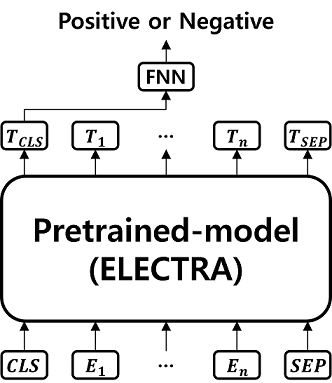

In [3]:
from IPython.display import Image
Image("/gdrive/MyDrive/04-2. SentimentAnalysis/ELECTRA.png")

<h1>ELECTRA 모델을 이용한 감성분류</h1>

In [4]:
import torch
import torch.nn as nn

from transformers import ElectraPreTrainedModel, ElectraModel


class SENTIMENT_CLASSIFIER(ElectraPreTrainedModel):

    def __init__(self, config):
        super(SENTIMENT_CLASSIFIER, self).__init__(config)

        # Electra 모델
        self.electra = ElectraModel(config)

        # 히든 사이즈
        self.hidden_size = config.hidden_size

        # 분류할 라벨의 개수
        self.num_labels = config.num_labels

        # 드랍아웃
        self.dropout = nn.Dropout(config.dropout)

        self.non_linear = nn.Sequential(nn.Linear(in_features=self.hidden_size, out_features=self.hidden_size),
                                        nn.ReLU(),
                                        nn.Linear(in_features=self.hidden_size, out_features=self.num_labels))

    def forward(self, input_ids, attention_mask, token_type_ids):
        outputs = self.electra(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        # (batch_size, max_length, hidden_size)
        electra_output = outputs[0]

        # (batch_size, hidden_size)
        cls_vector = electra_output[:, 0, :]
        cls_vector = self.dropout(cls_vector)

        # class_output : (batch_size, num_labels)
        cls_output = self.non_linear(cls_vector)

        return cls_output

In [5]:
import torch
import numpy as np
import re
from tqdm import tqdm

def read_data(file_path):
    with open(file_path, "r", encoding="utf8") as inFile:
        lines = inFile.readlines()

    datas = []
    for line in tqdm(lines, desc="read_data"):
        # 입력 데이터를 \t을 기준으로 분리
        pieces = line.strip().split("\t")
        assert len(pieces) == 2
        # 리뷰, 정답
        input_sequence, label = pieces[0], pieces[1]

        datas.append((input_sequence, label))

    return datas


def read_vocab_data(vocab_data_path):
    term2idx, idx2term = {"<PAD>":0}, {0:"<PAD>"}

    with open(vocab_data_path, "r", encoding="utf8") as inFile:
        lines = inFile.readlines()

    for line in lines:
        term = line.strip()
        term2idx[term] = len(term2idx)
        idx2term[term2idx[term]] = term

    return term2idx, idx2term


def convert_data2feature(datas, max_length, tokenizer, label2idx):
    input_ids_features, attention_mask_features, token_type_ids_features, label_id_features = [], [], [], []

    for input_sequence, label in tqdm(datas, desc="convert_data2feature"):
        
        # Electra tokenizer를 사용하여 입력 문장을 word piece 단위로 분리
        tokenized_sequence = tokenizer.tokenize(input_sequence)

        # CLS, SEP 토큰 추가
        tokens = [tokenizer.cls_token]
        tokens += tokenized_sequence
        tokens = tokens[:max_length - 1]
        tokens += [tokenizer.sep_token]

        # word piece들을 대응하는 index로 치환
        input_ids = tokenizer.convert_tokens_to_ids(tokens)
        # padding을 제외한 실제 데이터 정보를 반영해주기 위한 attention mask
        attention_mask = [1] * len(input_ids)
        # 각 문장을 구분하기 위한 정보를 반영해주기 위한 token type
        token_type_ids = [0] * len(input_ids)

        # padding 생성
        padding = [tokenizer._convert_token_to_id(tokenizer.pad_token)] * (max_length - len(input_ids))
        input_ids += padding
        attention_mask += padding
        token_type_ids += padding

        assert max_length == len(input_ids) == len(attention_mask) == len(token_type_ids)

        label_id = label2idx[label]

        # 변환한 데이터를 각 리스트에 저장
        input_ids_features.append(input_ids)
        attention_mask_features.append(attention_mask)
        token_type_ids_features.append(token_type_ids)
        label_id_features.append(label_id)

    # 변환한 데이터를 Tensor 객체에 담아 반환
    input_ids_features = torch.tensor(input_ids_features, dtype=torch.long)
    attention_mask_features = torch.tensor(attention_mask_features, dtype=torch.long)
    token_type_ids_features = torch.tensor(token_type_ids_features, dtype=torch.long)
    label_id_features = torch.tensor(label_id_features, dtype=torch.long)

    return input_ids_features, attention_mask_features, token_type_ids_features, label_id_features

In [6]:
import os
import numpy as np
from tqdm import tqdm
from sklearn.metrics import accuracy_score

import torch
from torch.utils.data import (DataLoader, TensorDataset, RandomSampler, SequentialSampler)
import torch.optim as optim

from transformers import ElectraPreTrainedModel, ElectraTokenizer, ElectraConfig


def train(config):
    # Electra config 객체 생성
    electra_config = ElectraConfig.from_pretrained(pretrained_model_name_or_path=config["pretrained_model_name_or_path"],
                                                   cache_dir=config["cache_dir_path"])
    setattr(electra_config, "num_labels", config["num_labels"])
    setattr(electra_config, "dropout", config["dropout"])

    # Electra tokenizer 객체 생성
    electra_tokenizer = ElectraTokenizer.from_pretrained(pretrained_model_name_or_path=config["pretrained_model_name_or_path"],
                                                         cache_dir=config["cache_dir_path"])

    # 라벨 딕셔너리 생성
    label2idx, idx2label = read_vocab_data(vocab_data_path=config["label_vocab_data_path"])

    # 학습 및 평가 데이터 읽기
    train_datas = read_data(config["train_data_path"])
    test_datas = read_data(config["test_data_path"])

    # 입력 데이터 전처리
    train_input_ids_features, train_attention_mask_features, train_token_type_ids_features, train_label_id_features = \
        convert_data2feature(train_datas, config["max_length"], electra_tokenizer, label2idx)
    test_input_ids_features, test_attention_mask_features, test_token_type_ids_features, test_label_id_features = \
        convert_data2feature(test_datas, config["max_length"], electra_tokenizer, label2idx)

    # 학습 데이터를 batch 단위로 추출하기 위한 DataLoader 객체 생성
    train_features = TensorDataset(train_input_ids_features, train_attention_mask_features, train_token_type_ids_features, train_label_id_features)
    train_dataloader = DataLoader(train_features, sampler=RandomSampler(train_features), batch_size=config["batch_size"])

    # 평가 데이터를 batch 단위로 추출하기 위한 DataLoader 객체 생성
    test_features = TensorDataset(test_input_ids_features, test_attention_mask_features, test_token_type_ids_features, test_label_id_features)
    test_dataloader = DataLoader(test_features, sampler=SequentialSampler(test_features), batch_size=config["batch_size"])

    # 사전 학습된 Electra 모델 파일로부터 가중치 불러옴
    model = SENTIMENT_CLASSIFIER.from_pretrained(pretrained_model_name_or_path=config["pretrained_model_name_or_path"],
                                                 cache_dir=config["cache_dir_path"],
                                                 config=electra_config).cuda()

    # loss를 계산하기 위한 함수
    loss_func = nn.CrossEntropyLoss()

    # 모델 학습을 위한 optimizer
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    # softmax 함수
    softmax = nn.Softmax(dim=-1)

    # 모델의 정확도를 저장하기 위한 변수
    max_accuracy = 0
    for epoch in range(config["epoch"]):
        model.train()

        total_loss = []
        for step, batch in tqdm(enumerate(train_dataloader), desc="epoch_{}_train".format(epoch+1), total=len(train_dataloader)):
            batch = tuple(t.cuda() for t in batch)
            input_ids, attention_mask, token_type_ids, label_id = batch

            # 역전파 단계를 실행하기 전에 변화도를 0으로 변경
            optimizer.zero_grad()

            # 모델 예측 결과
            hypothesis = model(input_ids, attention_mask, token_type_ids)

            # loss 계산
            loss = loss_func(hypothesis, label_id)

            # loss 값으로부터 모델 내부 각 매개변수에 대하여 gradient 계산
            loss.backward()
            # 모델 내부 각 매개변수 가중치 갱신
            optimizer.step()

            # batch 단위 loss 값 저장
            total_loss.append(loss.data.item())

        model.eval()

        # 모델의 출력 결과와 실제 정답값을 담을 리스트
        total_hypothesis, total_labels = [], []
        for step, batch in enumerate(tqdm(test_dataloader, desc="epoch_{}_test".format(epoch+1))):
            batch = tuple(t.cuda() for t in batch)
            input_ids, attention_mask, token_type_ids, label_id = batch

            with torch.no_grad():
                # 모델 예측 결과
                hypothesis = model(input_ids, attention_mask, token_type_ids)
                # 모델의 출력값에 softmax와 argmax 함수를 적용
                hypothesis = torch.argmax(softmax(hypothesis), dim=-1)

            # Tensor를 리스트로 변경
            hypothesis = hypothesis.cpu().detach().numpy().tolist()
            label_id = label_id.cpu().detach().numpy().tolist()

            total_hypothesis += hypothesis
            total_labels += label_id

        # 정확도 계산
        accuracy = accuracy_score(total_labels, total_hypothesis)

        # 현재의 정확도가 기존 정확도보다 높은 경우 모델 파일 저장
        if(max_accuracy < accuracy):
            max_accuracy = accuracy

            electra_config.save_pretrained(save_directory=config["output_dir_path"])
            electra_tokenizer.save_pretrained(save_directory=config["output_dir_path"])
            model.save_pretrained(save_directory=config["output_dir_path"])

            print("Average loss : {},\tAccuracy : {}".format(np.mean(total_loss), accuracy))
            print()

In [7]:
import os
import numpy as np
from tqdm import tqdm
from sklearn.metrics import accuracy_score

import torch
from torch.utils.data import (DataLoader, SequentialSampler, TensorDataset)

from transformers import ElectraPreTrainedModel, ElectraTokenizer, ElectraConfig


def test(config):
    # Electra config 객체 생성
    electra_config = ElectraConfig.from_pretrained(pretrained_model_name_or_path=config["save_dir_path"],
                                                   cache_dir=config["cache_dir_path"])

    # Electra tokenizer 객체 생성
    electra_tokenizer = ElectraTokenizer.from_pretrained(pretrained_model_name_or_path=config["save_dir_path"],
                                                         cache_dir=config["cache_dir_path"])

    # 라벨 딕셔너리 생성
    label2idx, idx2label = read_vocab_data(vocab_data_path=config["label_vocab_data_path"])

    # 평가 데이터 읽기
    test_datas = read_data(config["test_data_path"])[:1000]

    # 입력 데이터 전처리
    test_input_ids_features, test_attention_mask_features, test_token_type_ids_features, test_label_id_features = \
        convert_data2feature(test_datas, config["max_length"], electra_tokenizer, label2idx)

    # 평가 데이터를 batch 단위로 추출하기 위한 DataLoader 객체 생성
    test_features = TensorDataset(test_input_ids_features, test_attention_mask_features, test_token_type_ids_features, test_label_id_features)
    test_dataloader = DataLoader(test_features, sampler=SequentialSampler(test_features), batch_size=config["batch_size"])

    # 학습한 모델 파일로부터 가중치 불러옴
    model = SENTIMENT_CLASSIFIER.from_pretrained(pretrained_model_name_or_path=config["save_dir_path"],
                                                 cache_dir=config["cache_dir_path"],
                                                 config=electra_config).cuda()

    # softmax 함수
    softmax = nn.Softmax(dim=-1)

    model.eval()

    show_count = 0
    total_hypothesis, total_labels = [], []
    for step, batch in enumerate(tqdm(test_dataloader, desc="test")):
        batch = tuple(t.cuda() for t in batch)
        input_ids, attention_mask, token_type_ids, label_id = batch

        with torch.no_grad():
            # 모델 예측 결과
            hypothesis = model(input_ids, attention_mask, token_type_ids)
            # 모델의 출력값에 softmax와 argmax 함수를 적용
            hypothesis = torch.argmax(softmax(hypothesis), dim=-1)

        # Tensor를 리스트로 변경
        hypothesis = hypothesis.cpu().detach().numpy().tolist()
        label_id = label_id.cpu().detach().numpy().tolist()

        total_hypothesis += hypothesis
        total_labels += label_id

        # padding 제거 및 모델 예측 결과와 정답 비교
        if(show_count <= 10):
            for index in range(len(input_ids)):
                input_tokens = electra_tokenizer.convert_ids_to_tokens(input_ids[index])
                input_sequence = electra_tokenizer.convert_tokens_to_string(input_tokens[1:input_tokens.index(electra_tokenizer.sep_token)])
                predict = idx2label[hypothesis[index]]
                correct = idx2label[label_id[index]]

            print("\n입력 : {}".format(input_sequence))
            print("출력 : {}".format(predict))
            print("정답 : {}\n".format(correct))

            show_count += 1

    # 정확도 출력
    print("Accuracy : {}".format(accuracy_score(total_labels, total_hypothesis)))

In [8]:
import os
import random
import numpy as np
import torch

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)


if(__name__=="__main__"):
    root_dir = "/gdrive/MyDrive/04-2. SentimentAnalysis"
    save_dir = os.path.join(root_dir, "save")
    output_dir = os.path.join(root_dir, "output")
    cache_dir = os.path.join(root_dir, "cache")
    
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    if not os.path.exists(cache_dir):
        os.makedirs(cache_dir)

    set_seed(seed=1234)

    config = {"mode": "train",
              "train_data_path":os.path.join(root_dir, "train_datas.txt"),
              "test_data_path": os.path.join(root_dir, "test_datas.txt"),
              "output_dir_path":output_dir,
              "save_dir_path": save_dir,
              "cache_dir_path": cache_dir,
              "pretrained_model_name_or_path":"monologg/koelectra-base-discriminator",
              "label_vocab_data_path": os.path.join(root_dir, "label_vocab.txt"),
              "num_labels": 3,
              "max_length": 142,
              "epoch":10,
              "batch_size":64,
              "dropout":0.3
              }

    if(config["mode"] == "train"):
        train(config)
    else:
        test(config)

Downloading:   0%|          | 0.00/467 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/273k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/51.0 [00:00<?, ?B/s]

convert_data2feature: 100%|██████████| 1000/1000 [00:00<00:00, 4633.99it/s]


Downloading:   0%|          | 0.00/423M [00:00<?, ?B/s]

Some weights of the model checkpoint at monologg/koelectra-base-discriminator were not used when initializing SENTIMENT_CLASSIFIER: ['discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.weight']
- This IS expected if you are initializing SENTIMENT_CLASSIFIER from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SENTIMENT_CLASSIFIER from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of SENTIMENT_CLASSIFIER were not initialized from the model checkpoint at monologg/koelectra-base-discriminator and are newly initialized: ['non_linear.0.weight', 'non_linear.2.weight', 'non_li

Average loss : 0.49980753394448835,	Accuracy : 0.837



epoch_2_test: 100%|██████████| 16/16 [00:08<00:00,  1.90it/s]


Average loss : 0.31351306692809816,	Accuracy : 0.845



epoch_5_test: 100%|██████████| 16/16 [00:08<00:00,  1.90it/s]


Average loss : 0.10760461054386417,	Accuracy : 0.848



epoch_10_test: 100%|██████████| 16/16 [00:08<00:00,  1.88it/s]


In [9]:
import os
import random
import numpy as np
import torch

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)


if(__name__=="__main__"):
    root_dir = "/gdrive/MyDrive/2021 하계 강의자료/04-2. Sentiment Analysis/Practice"
    save_dir = os.path.join(root_dir, "save")
    output_dir = os.path.join(root_dir, "output")
    cache_dir = os.path.join(root_dir, "cache")
    
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    if not os.path.exists(cache_dir):
        os.makedirs(cache_dir)

    set_seed(seed=1234)

    config = {"mode": "test",
              "train_data_path":os.path.join(root_dir, "train_datas.txt"),
              "test_data_path": os.path.join(root_dir, "test_datas.txt"),
              "output_dir_path":output_dir,
              "save_dir_path": save_dir,
              "cache_dir_path": cache_dir,
              "pretrained_model_name_or_path":"monologg/koelectra-base-discriminator",
              "label_vocab_data_path": os.path.join(root_dir, "label_vocab.txt"),
              "num_labels": 3,
              "max_length": 142,
              "epoch":10,
              "batch_size":64,
              "dropout":0.3
              }

    if(config["mode"] == "train"):
        train(config)
    else:
        test(config)

test:   6%|▋         | 1/16 [00:00<00:08,  1.67it/s]


입력 : " " " " " " " 결혼은 현실이에요 징징징 " " " " 성현아 벗겨놓고 이 정도 얘기 밖에 못 하냐 . " " "
출력 : negative
정답 : negative



test:  12%|█▎        | 2/16 [00:01<00:07,  1.76it/s]


입력 : 정말 가슴아픈영화 . . . . 질리지도 않는영화 . . . . 몇번을봐도 . . . 음악도 너무 좋아요 . . . OST도 구해 들었다는 . . .
출력 : positive
정답 : positive



test:  19%|█▉        | 3/16 [00:01<00:07,  1.79it/s]


입력 : 이게영화냐 ? 첫장면부터 역겨웠다 분위기있는척앵글잡으면 괜찮은영화인거같지 ? 허세덩어리
출력 : negative
정답 : negative



test:  25%|██▌       | 4/16 [00:02<00:06,  1.82it/s]


입력 : 책으로 먼저 접한 , 폭풍의 언덕 . 21살 이었던 , 내게 사랑의 그 진한밀도를 알게 해준 .
출력 : positive
정답 : positive



test:  31%|███▏      | 5/16 [00:02<00:06,  1.82it/s]


입력 : 논스톱 , 뉴논스톱 , 논스톱3 , 논스톱 , 4 , 논스톱5 , 레인보우로망스
출력 : negative
정답 : negative



test:  38%|███▊      | 6/16 [00:03<00:05,  1.83it/s]


입력 : 쉬리에서 한 10년은 퇴보한 방화 수준의 망작
출력 : negative
정답 : negative



test:  44%|████▍     | 7/16 [00:03<00:04,  1.82it/s]


입력 : 완전 . 잼잇엇어요 ! ! ! 정말 . 현재의 나를 보는 듯한느낌
출력 : positive
정답 : positive



test:  50%|█████     | 8/16 [00:04<00:04,  1.82it/s]


입력 : 빨갱이는 빨갱이일뿐 . .
출력 : negative
정답 : negative



test:  56%|█████▋    | 9/16 [00:04<00:03,  1.83it/s]


입력 : 재미없다 . . 옹박 오리지날 1편빼고 만들지 말았어야했다 . .
출력 : negative
정답 : negative



test:  62%|██████▎   | 10/16 [00:05<00:03,  1.83it/s]


입력 : 평점이 8점대라니 .
출력 : negative
정답 : positive



test:  69%|██████▉   | 11/16 [00:06<00:02,  1.83it/s]


입력 : 짐캐리만의 영화
출력 : negative
정답 : positive



test: 100%|██████████| 16/16 [00:08<00:00,  1.95it/s]

Accuracy : 0.845
